<a href="https://colab.research.google.com/github/paulrolland1602/IAE_METZ_2026_EMPIRICAL_FINANCLE/blob/main/SCRIPTS/devoir_python_Yannis_Paul.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import yfinance as yf
print('Notebook fonctionnel !')

Notebook fonctionnel !


In [8]:
# 1. Bibliothèques de base (celles que tu as envoyées)
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Ajouts nécessaires pour ton projet spécifique
from scipy.stats import norm  # Pour les calculs de VaR et stats
import datetime as dt         # Pour gérer les périodes fév/juin 2025 proprement
from scipy.optimize import minimize # Pour trouver précisément le portefeuille optimal

# Configuration du style graphique pour ton devoir
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_theme(style="ticks")
%matplotlib inline

In [9]:
import yfinance as yf

# Liste propre sans doublon (exit SPY)
TICKERS = ['XLK', 'XLV', 'XLF', 'XLE', 'ITA', 'XLP', 'XLRE']

# Dates clés basées sur ton graphique
START_HISTORY = '2024-06-01'
DATE_CHOC = '2025-03-15' # Moment où la FED annonce "Pas de baisse"
END_STUDY = '2025-06-30'

# 1) Téléchargement
data = yf.download(TICKERS, start=START_HISTORY, end=END_STUDY)['Close']
rets = data.pct_change().dropna()

# 2) Séparation en deux périodes (Avant / Après)
R_avant = rets.loc['2025-01-01':DATE_CHOC]
R_apres = rets.loc[DATE_CHOC:END_STUDY]

print(f"Période Avant : {len(R_avant)} jours | Période Après : {len(R_apres)} jours")

/tmp/ipython-input-2308018981.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(TICKERS, start=START_HISTORY, end=END_STUDY)['Close']
[*********************100%***********************]  7 of 7 completed

Période Avant : 49 jours | Période Après : 72 jours


In [10]:
# --- ÉTAPE 4 : PRÉPARATION DES PARAMÈTRES STATISTIQUES (ANNUALISÉS) ---

# On définit le facteur d'annualisation (252 jours de bourse)
ANN = 252

# 1. Période AVANT (Anticipation)
mu_avant = R_avant.mean() * ANN
cov_avant = R_avant.cov() * ANN

# 2. Période APRÈS (Choc FED)
mu_apres = R_apres.mean() * ANN
cov_apres = R_apres.cov() * ANN

# 3. Définition du Taux Sans Risque (Risk-Free Rate)
# Pour 2025, on peut prendre 4.5% (0.045) car la FED ne baisse pas les taux
rf = 0.045

print("Statistiques calculées et annualisées.")
print(f"Rendement moyen Tech (XLK) Avant: {mu_avant['XLK']:.2%}")
print(f"Rendement moyen Tech (XLK) Après: {mu_apres['XLK']:.2%}")

Statistiques calculées et annualisées.
Rendement moyen Tech (XLK) Avant: -38.84%
Rendement moyen Tech (XLK) Après: 64.21%


In [11]:
# --- ÉTAPE 5 : SIMULATION DE MONTE CARLO ---

def simulation_mc(mu, cov, rf, n_sims=10000):
    n_assets = len(mu)
    # On stocke : [Rendement, Volatilité, Sharpe, Poids...]
    results = np.zeros((3 + n_assets, n_sims))

    for i in range(n_sims):
        # 1. Générer des poids aléatoires dont la somme fait 1 (100%)
        w = np.random.random(n_assets)
        w /= np.sum(w)

        # 2. Calcul du rendement et du risque du portefeuille
        p_ret = np.sum(mu * w)
        p_std = np.sqrt(np.dot(w.T, np.dot(cov, w)))

        # 3. Calcul du Sharpe Ratio
        p_sharpe = (p_ret - rf) / p_std

        # 4. Stockage
        results[0,i] = p_ret
        results[1,i] = p_std
        results[2,i] = p_sharpe
        results[3:,i] = w

    # On transforme en DataFrame pour que ce soit facile à manipuler
    cols = ['Ret', 'Vol', 'Sharpe'] + list(mu.index)
    return pd.DataFrame(results.T, columns=cols)

# Exécution pour les deux périodes
df_avant = simulation_mc(mu_avant, cov_avant, rf)
df_apres = simulation_mc(mu_apres, cov_apres, rf)

print("Simulations terminées !")
print(f"Meilleur Sharpe AVANT : {df_avant['Sharpe'].max():.2f}")
print(f"Meilleur Sharpe APRÈS : {df_apres['Sharpe'].max():.2f}")

Simulations terminées !
Meilleur Sharpe AVANT : 1.60
Meilleur Sharpe APRÈS : 1.92


<>:24: SyntaxWarning: invalid escape sequence '\s'
<>:24: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2349620829.py:24: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('Volatilité Annualisée ($\sigma$)', fontsize=12)


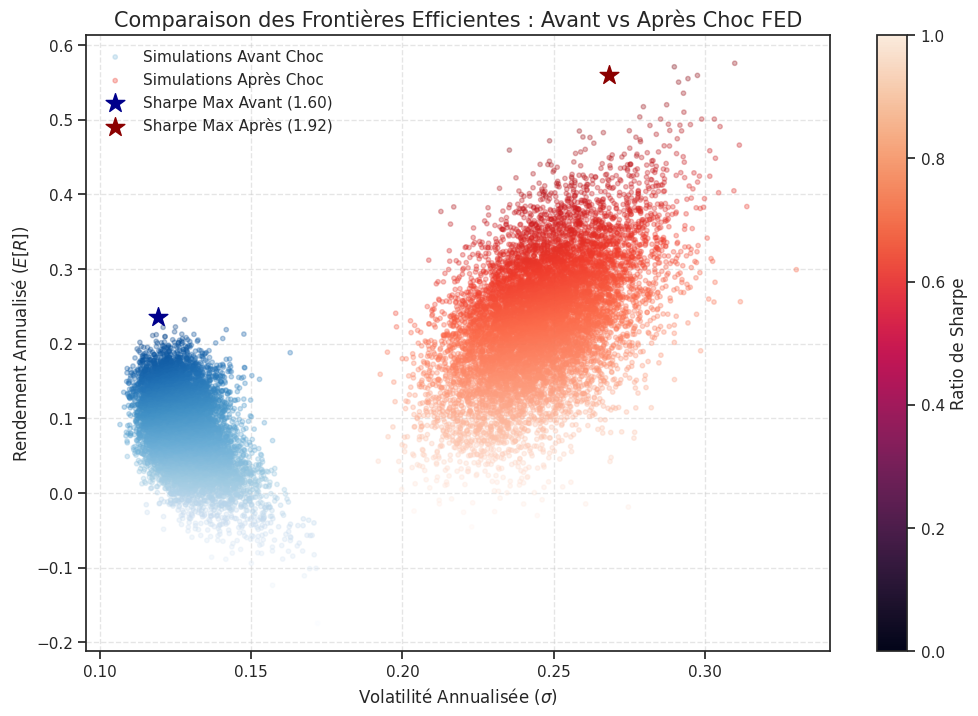

In [12]:
# --- ÉTAPE 6 : PLOT DE LA FRONTIÈRE EFFICIENTE ---

plt.figure(figsize=(12, 8))

# Nuage de points AVANT (Bleu)
plt.scatter(df_avant['Vol'], df_avant['Ret'], c=df_avant['Sharpe'], cmap='Blues',
            s=10, alpha=0.3, label='Simulations Avant Choc')

# Nuage de points APRÈS (Rouge)
plt.scatter(df_apres['Vol'], df_apres['Ret'], c=df_apres['Sharpe'], cmap='Reds',
            s=10, alpha=0.3, label='Simulations Après Choc')

# Extraction des portefeuilles optimaux (Sharpe Max)
best_avant = df_avant.iloc[df_avant['Sharpe'].idxmax()]
best_apres = df_apres.iloc[df_apres['Sharpe'].idxmax()]

# Marquer les points optimaux
plt.scatter(best_avant['Vol'], best_avant['Ret'], color='darkblue', marker='*',
            s=200, label=f'Sharpe Max Avant ({best_avant["Sharpe"]:.2f})')
plt.scatter(best_apres['Vol'], best_apres['Ret'], color='darkred', marker='*',
            s=200, label=f'Sharpe Max Après ({best_apres["Sharpe"]:.2f})')

plt.title('Comparaison des Frontières Efficientes : Avant vs Après Choc FED', fontsize=15)
plt.xlabel('Volatilité Annualisée ($\sigma$)', fontsize=12)
plt.ylabel('Rendement Annualisé ($E[R]$)', fontsize=12)
plt.colorbar(label='Ratio de Sharpe')
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

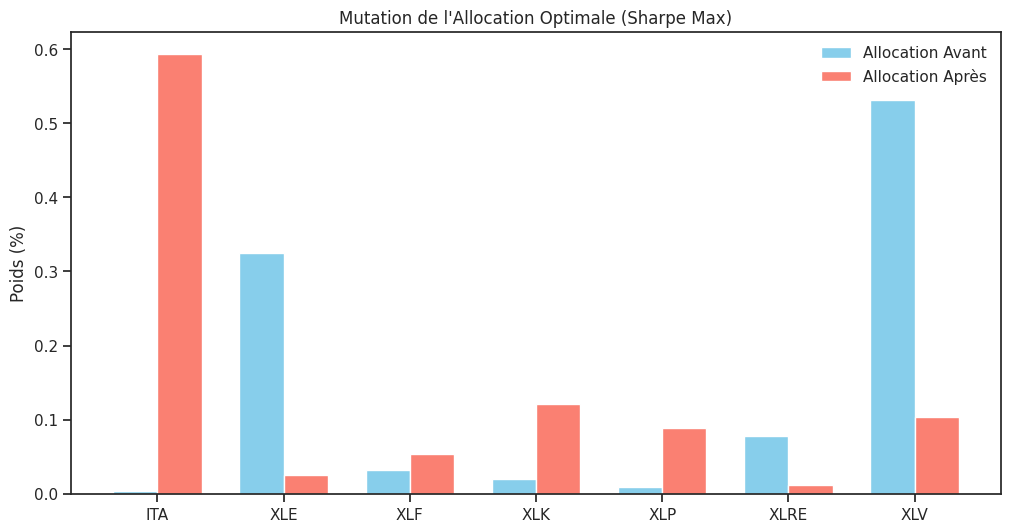

In [13]:
# Extraction des poids uniquement
w_avant = best_avant[list(mu_avant.index)]
w_apres = best_apres[list(mu_apres.index)]

# Création du graphique
plt.figure(figsize=(12, 6))
x = np.arange(len(w_avant))
width = 0.35

plt.bar(x - width/2, w_avant, width, label='Allocation Avant', color='skyblue')
plt.bar(x + width/2, w_apres, width, label='Allocation Après', color='salmon')

plt.xticks(x, w_avant.index)
plt.ylabel('Poids (%)')
plt.title('Mutation de l\'Allocation Optimale (Sharpe Max)')
plt.legend()
plt.show()

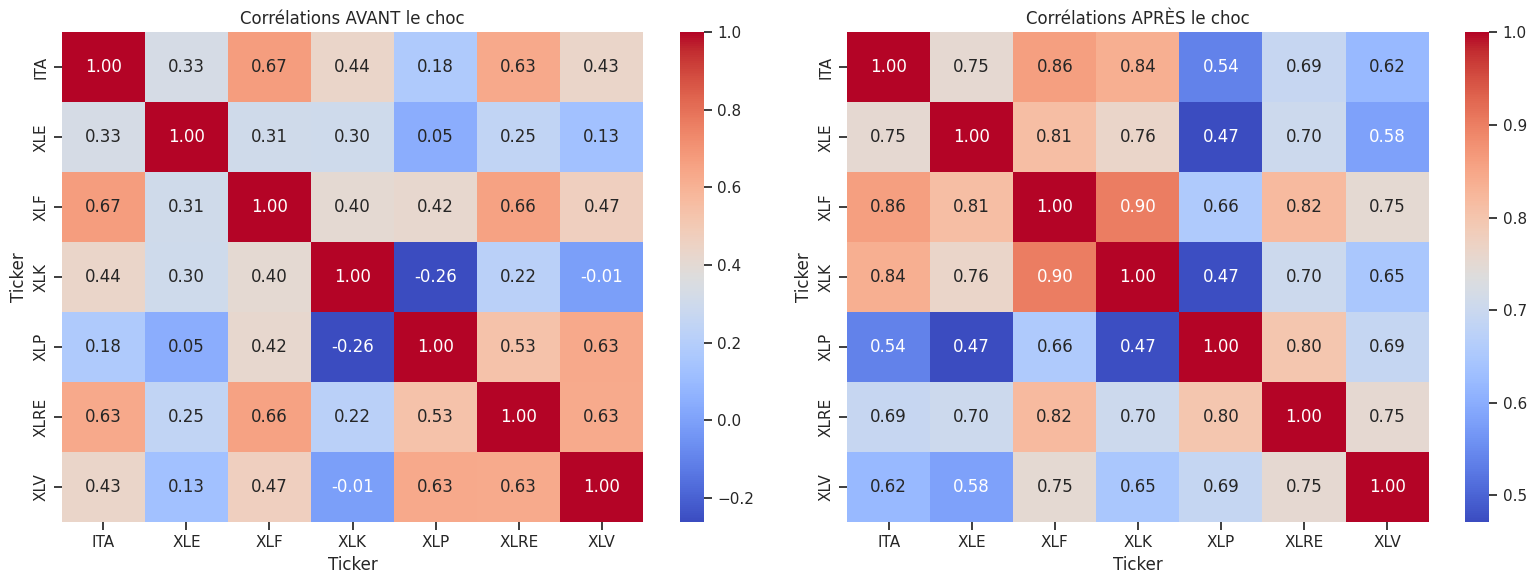

In [14]:
# --- ÉTAPE 7 : ANALYSE DE LA CORRÉLATION (DIVERSIFICATION) ---

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Corrélation Avant
sns.heatmap(R_avant.corr(), annot=True, cmap='coolwarm', fmt=".2f", ax=ax1)
ax1.set_title('Corrélations AVANT le choc')

# Corrélation Après
sns.heatmap(R_apres.corr(), annot=True, cmap='coolwarm', fmt=".2f", ax=ax2)
ax2.set_title('Corrélations APRÈS le choc')

plt.tight_layout()
plt.show()

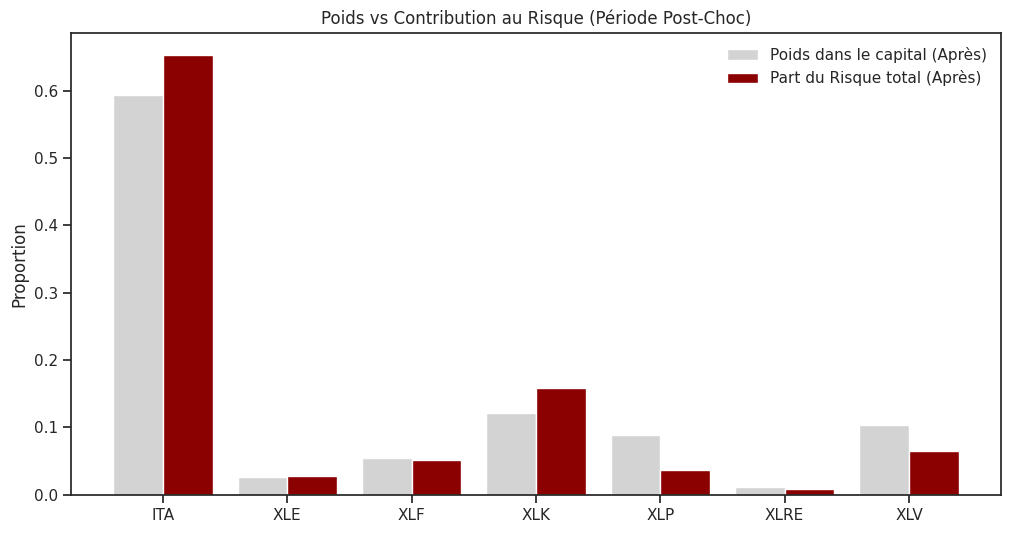

In [15]:
# --- ÉTAPE 8 : CONTRIBUTION AU RISQUE (PORTFOLIO BEYOND WEIGHTS) ---

def risk_contribution(weights, cov_matrix):
    # Volatilité totale du portefeuille
    portfolio_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    # Contribution marginale de chaque actif
    marginal_contrib = np.dot(cov_matrix, weights) / portfolio_vol
    # Contribution réelle (poids * contribution marginale)
    component_contrib = weights * marginal_contrib
    return component_contrib / portfolio_vol # Normalisé à 100%

# Calcul pour les deux portefeuilles optimaux
rc_avant = risk_contribution(best_avant[list(mu_avant.index)].values, cov_avant)
rc_apres = risk_contribution(best_apres[list(mu_apres.index)].values, cov_apres)

# Plot de comparaison
labels = list(mu_avant.index)
x = np.arange(len(labels))

plt.figure(figsize=(12, 6))
plt.bar(x - 0.2, best_apres[labels], 0.4, label='Poids dans le capital (Après)', color='lightgrey')
plt.bar(x + 0.2, rc_apres, 0.4, label='Part du Risque total (Après)', color='darkred')

plt.xticks(x, labels)
plt.ylabel('Proportion')
plt.title('Poids vs Contribution au Risque (Période Post-Choc)')
plt.legend()
plt.show()

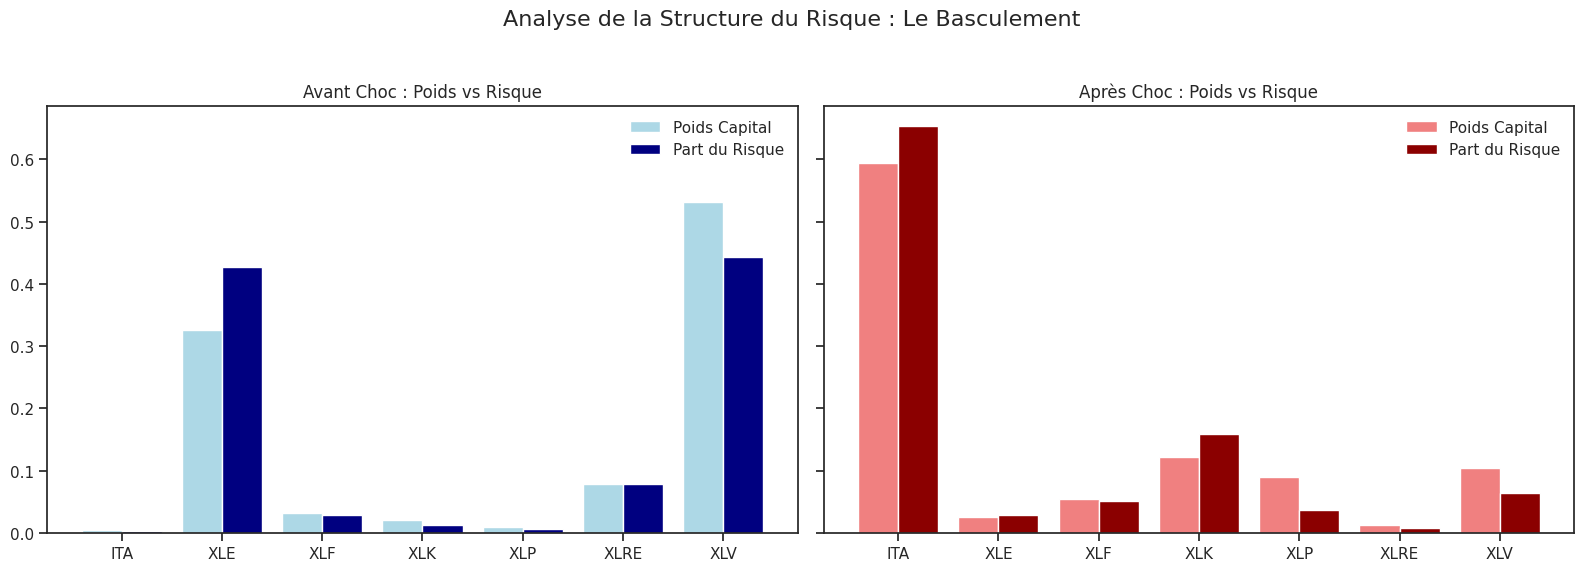

In [16]:
# --- ÉTAPE 8 : COMPARISON DES CONTRIBUTIONS AU RISQUE (AVANT VS APRÈS) ---

# Calcul des contributions pour les deux périodes
rc_avant = risk_contribution(best_avant[list(mu_avant.index)].values, cov_avant)
rc_apres = risk_contribution(best_apres[list(mu_apres.index)].values, cov_apres)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Graphique AVANT
ax1.bar(x - 0.2, best_avant[labels], 0.4, label='Poids Capital', color='lightblue')
ax1.bar(x + 0.2, rc_avant, 0.4, label='Part du Risque', color='navy')
ax1.set_title('Avant Choc : Poids vs Risque')
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.legend()

# Graphique APRÈS
ax2.bar(x - 0.2, best_apres[labels], 0.4, label='Poids Capital', color='lightcoral')
ax2.bar(x + 0.2, rc_apres, 0.4, label='Part du Risque', color='darkred')
ax2.set_title('Après Choc : Poids vs Risque')
ax2.set_xticks(x)
ax2.set_xticklabels(labels)
ax2.legend()

plt.suptitle('Analyse de la Structure du Risque : Le Basculement', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [17]:
# --- ÉTAPE 9 : ANALYSE DES PERTES EXTRÊMES (VaR & CVaR) ---

def calculate_extreme_risk(returns_df, weights):
    # Rendements historiques du portefeuille
    port_rets = returns_df.dot(weights)

    # VaR Historique 95%
    var_95 = np.percentile(port_rets, 5)

    # Expected Shortfall (Moyenne des rendements inférieurs à la VaR)
    cvar_95 = port_rets[port_rets <= var_95].mean()

    return var_95, cvar_95

# Calcul pour les deux périodes
var_av, cvar_av = calculate_extreme_risk(R_avant, best_avant[labels])
var_ap, cvar_ap = calculate_extreme_risk(R_apres, best_apres[labels])

print(f"--- ANALYSE DE RISQUE (Seuil 95%) ---")
print(f"Avant Choc : VaR = {var_av:.2%}, CVaR = {cvar_av:.2%}")
print(f"Après Choc : VaR = {var_ap:.2%}, CVaR = {cvar_ap:.2%}")

--- ANALYSE DE RISQUE (Seuil 95%) ---
Avant Choc : VaR = -1.03%, CVaR = -1.10%
Après Choc : VaR = -1.85%, CVaR = -3.96%


In [18]:
# --- ÉTAPE 10 : TABLEAU BILAN SYNTHÉTIQUE ---

# Création du dictionnaire de données
summary_data = {
    "Indicateur": [
        "Rendement Annualisé (E[R])",
        "Volatilité Annualisée (σ)",
        "Ratio de Sharpe",
        "Value-at-Risk (VaR 95%)",
        "Expected Shortfall (CVaR 95%)",
        "Poids Secteur Tech (XLK)",
        "Poids Secteur Finance (XLF)"
    ],
    "Avant Choc (Euphorie)": [
        f"{best_avant['Ret']:.2%}",
        f"{best_avant['Vol']:.2%}",
        f"{best_avant['Sharpe']:.2f}",
        f"{var_av:.2%}",
        f"{cvar_av:.2%}",
        f"{best_avant['XLK']:.2%}",
        f"{best_avant['XLF']:.2%}"
    ],
    "Après Choc (Réalité FED)": [
        f"{best_apres['Ret']:.2%}",
        f"{best_apres['Vol']:.2%}",
        f"{best_apres['Sharpe']:.2f}",
        f"{var_ap:.2%}",
        f"{cvar_ap:.2%}",
        f"{best_apres['XLK']:.2%}",
        f"{best_apres['XLF']:.2%}"
    ]
}

# Transformation en DataFrame pour un affichage propre
df_bilan = pd.DataFrame(summary_data)

# Affichage avec style
print("--- TABLEAU RÉCAPITULATIF DES STRATÉGIES ---")
display(df_bilan) # Utilise display pour un rendu propre dans le notebook

--- TABLEAU RÉCAPITULATIF DES STRATÉGIES ---


,Indicateur,Avant Choc (Euphorie),Après Choc (Réalité FED)
0,Rendement Annualisé (E[R]),23.62%,55.92%
1,Volatilité Annualisée (σ),11.92%,26.83%
2,Ratio de Sharpe,1.60,1.92
3,Value-at-Risk (VaR 95%),-1.03%,-1.85%
4,Expected Shortfall (CVaR 95%),-1.10%,-3.96%
5,Poids Secteur Tech (XLK),2.01%,12.10%
6,Poids Secteur Finance (XLF),3.19%,5.41%
